### Imports

In [68]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from tqdm import tqdm

In [69]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # PyTorch v0.4.0
print(device)

cuda


### Data Loading & Cleaning

In [70]:
# Load dataset
data_path = 'spain_energy_meteo_data.csv'
df = pd.read_csv(data_path, parse_dates=['Date'], index_col='Date')

# Use all features for input
all_features = df.columns.tolist()

# Handle missing values
data = df.fillna(method='ffill')

C:\Users\student11\AppData\Local\Temp\ipykernel_8324\1784617096.py:9: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = df.fillna(method='ffill')


In [71]:
display(data)

,Global Horizontal Irradiance,Mean Sea Level Pressure,Air Temperature,Total Precipitation,Wind Speed_x,Wind Speed_y,Electricity Demand,Hydropower reservoir,Hydropower run-of-river,Solar PV Power,Wind Power Onshore
Date,,,,,,,,,,,
1980-01-01,63.712332,101892.963958,282.782622,0.001628,3.967427,6.825222,555442.4,75105.17,27625.16,7414.011781,241681.204853
1980-01-02,76.356610,102279.375083,280.568923,0.000416,3.075484,5.265852,668316.5,74774.20,27676.85,9667.063190,141812.976918
1980-01-03,103.318422,102547.714417,277.943976,0.000005,1.731207,2.884409,692024.2,74066.41,28220.82,14965.925374,28256.394755
1980-01-04,99.630959,102265.270542,278.233487,0.000728,1.816051,3.011657,693162.4,74689.07,28344.47,14105.305812,36945.997648
1980-01-05,84.680324,102225.539208,278.408883,0.000794,2.186170,3.756692,624292.7,74882.60,28480.01,11298.820055,72234.129754
...,...,...,...,...,...,...,...,...,...,...,...
2025-02-24,143.957778,102796.901583,282.747021,0.001501,2.496270,4.200499,700110.3,66117.47,30107.25,15865.123549,95783.220015
2025-02-25,110.305063,102545.382667,282.309362,0.001773,3.193231,5.403183,725569.3,66875.40,30080.05,11142.786919,138396.892727
2025-02-26,187.718245,102601.983000,280.700744,0.000090,2.010059,3.276983,724012.9,64955.26,29987.86,21820.251802,42084.705472


In [72]:
data_y = data[['Global Horizontal Irradiance', 'Mean Sea Level Pressure', 'Air Temperature', 'Total Precipitation', 'Wind Speed_x', 'Wind Speed_y']]

targets = data_y.columns.tolist()

print(targets)

['Global Horizontal Irradiance', 'Mean Sea Level Pressure', 'Air Temperature', 'Total Precipitation', 'Wind Speed_x', 'Wind Speed_y']


In [73]:
display(data_y)

,Global Horizontal Irradiance,Mean Sea Level Pressure,Air Temperature,Total Precipitation,Wind Speed_x,Wind Speed_y
Date,,,,,,
1980-01-01,63.712332,101892.963958,282.782622,0.001628,3.967427,6.825222
1980-01-02,76.356610,102279.375083,280.568923,0.000416,3.075484,5.265852
1980-01-03,103.318422,102547.714417,277.943976,0.000005,1.731207,2.884409
1980-01-04,99.630959,102265.270542,278.233487,0.000728,1.816051,3.011657
1980-01-05,84.680324,102225.539208,278.408883,0.000794,2.186170,3.756692
...,...,...,...,...,...,...
2025-02-24,143.957778,102796.901583,282.747021,0.001501,2.496270,4.200499
2025-02-25,110.305063,102545.382667,282.309362,0.001773,3.193231,5.403183
2025-02-26,187.718245,102601.983000,280.700744,0.000090,2.010059,3.276983


### Data Normalization

In [74]:
# Normalize data
# scalerX = MinMaxScaler()
scalerX = StandardScaler()
# scalerX = RobustScaler()
dataX_scaled = scalerX.fit_transform(data)

# scalerY = MinMaxScaler()
scalerY = StandardScaler()
# scalerY = RobustScaler()
data_y_scaled = scalerY.fit_transform(data_y)

In [75]:
print(dataX_scaled.shape, data_y_scaled.shape) # (samples, features) (samples, targets)

(16496, 11) (16496, 6)


### Sequence Generation for LSTM

In [76]:
def create_sequences(dataX, data_y, seq_length, prediction_horizon):
    X, y = [], []
    for i in range(len(data) - seq_length - prediction_horizon + 1):
        X.append(dataX[i:i+seq_length])
        y.append(data_y[i+seq_length+prediction_horizon-1])
    return np.array(X), np.array(y)

seq_length = 30*10  # Use past 30 days to predict
prediction_horizon = 30  # Predict 30 days ahead

X, y = create_sequences(dataX_scaled, data_y_scaled, seq_length, prediction_horizon)

In [77]:
print(X.shape, y.shape) # (samples, sequence length, features), (samples, features)

(16167, 300, 11) (16167, 6)


### Train-Test Split & Tensor Conversion

In [78]:
# Split data into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, shuffle=False)

# Convert data to PyTorch tensors
X_train, X_val, X_test, y_train, y_val, y_test = (
    torch.tensor(X_train, dtype=torch.float32),
    torch.tensor(X_val, dtype=torch.float32),
    torch.tensor(X_test, dtype=torch.float32),
    torch.tensor(y_train, dtype=torch.float32),
    torch.tensor(y_val, dtype=torch.float32),
    torch.tensor(y_test, dtype=torch.float32)
)

In [79]:
from torch.utils.data import DataLoader, TensorDataset

batch_size = 64

# Create TensorDatasets
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print('Train:', len(train_dataset))
print('Val:', len(val_dataset))
print('Test:', len(test_dataset))

Train: 11316
Val: 2425
Test: 2426


### LSTM Model Definition

### GRU Model Definition

In [80]:
class GRUModelMeteo(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.3):
        super(GRUModelMeteo, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc1 = nn.Linear(hidden_size, hidden_size // 2)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size // 2, output_size)
        
        # Initialize GRU weights
        for name, param in self.gru.named_parameters():
            if 'weight_ih' in name:
                nn.init.xavier_uniform_(param)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param)
            elif 'bias' in name:
                nn.init.constant_(param, 0)
        
        # Initialize FC weights
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.constant_(self.fc1.bias, 0)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.constant_(self.fc2.bias, 0)
    
    def forward(self, x, h0=None):
        # If hidden state is not provided, initialize it as zeros
        if h0 is None:
            h0 = torch.zeros(self.gru.num_layers, x.size(0), self.gru.hidden_size).to(x.device)
        
        gru_out, hn = self.gru(x, h0)
        x = self.fc1(gru_out[:, -1, :])  # Use the last output of the GRU
        x = self.relu(x)
        return self.fc2(x), hn

input_size = len(all_features)
hidden_size = 200  # Increased hidden size for better feature learning
num_layers = 4  # Increased number of layers for deeper representation
output_size = len(targets)
dropout = 0.1  # Added dropout for regularization

gru_model = GRUModelMeteo(input_size, hidden_size, num_layers, output_size, dropout).to(device)

print(f"Nb of hyperparamters in {gru_model.__class__.__name__}: {sum(p.numel() for p in gru_model.parameters() if p.requires_grad):,}")

Nb of hyperparamters in GRUModelMeteo: 872,106


### Loss Function & Optimizer

In [81]:
criterion = nn.MSELoss()
optimizer = optim.Adam(gru_model.parameters(), lr=0.001)

### Model Training

In [82]:
epochs = 10

train_loss_arr = []
val_loss_arr = []

train_mae_arr = []
val_mae_arr = []
train_mse_arr = []
val_mse_arr = []
train_rmse_arr = []
val_rmse_arr = []

# for epoch in tqdm(range(epochs), desc="Training Progress", unit="epoch"):
for epoch in range(epochs):
    print(f'Epoch {epoch+1}/{epochs}')
    gru_model.train()
    train_loss = 0.0
    acc_train = 0.0
    mae_train = 0.0
    mse_train = 0.0
    rmse_train = 0.0
    
    h0 = None  # Initialize hidden and cell states
    
    for X_batch, y_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False):
        if X_batch.size(0) != batch_size:
            continue
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        
        outputs, h0 = gru_model(X_batch, h0)
        
        # Detach hidden and cell states to prevent backpropagation through the entire sequence
        h0 = h0.detach()
        
        loss = criterion(outputs, y_batch)
        
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * X_batch.size(0)
        acc_train += (outputs== y_batch).type(torch.float).sum().item()
    
        # Compute training accuracy
        with torch.no_grad():
            y_pred_train_np = outputs.cpu().numpy()
            y_train_np = y_batch.cpu().numpy()
            
            # Inverse transform predictions and actual values
            y_pred_train_inv = scalerY.inverse_transform(y_pred_train_np)
            y_train_inv = scalerY.inverse_transform(y_train_np)
            
            # Compute evaluation metrics
            mae_train += mean_absolute_error(y_train_inv, y_pred_train_inv)
            mse_train += mean_squared_error(y_train_inv, y_pred_train_inv)
            rmse_train += np.sqrt(mse_train)
            
            
    train_loss /= len(train_loader.dataset)
    acc_train /= len(train_loader.dataset)
    mae_train /= len(train_loader.dataset)
    mse_train /= len(train_loader.dataset)
    rmse_train /= len(train_loader.dataset)
    
    train_loss_arr.append(train_loss)
    train_mae_arr.append(mae_train)
    train_mse_arr.append(mse_train)
    train_rmse_arr.append(rmse_train)
        
    # Validation phase
    gru_model.eval()
    val_loss = 0.0
    mae_val = 0.0
    mse_val = 0.0
    rmse_val = 0.0
    acc_val = 0.0
    
    h0 = None  # Initialize hidden and cell states
    
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            if X_batch.size(0) != batch_size:
                continue
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            outputs, h0 = gru_model(X_batch, h0)
            
            # Detach hidden and cell states to prevent backpropagation through the entire sequence
            h0 = h0.detach()
            
            loss = criterion(outputs, y_batch)
            
            val_loss += loss.item() * X_batch.size(0)
            acc_val += (outputs == y_batch).type(torch.float).sum().item()
    
            # Compute validation accuracy
            with torch.no_grad():
                y_pred_val = outputs
                y_pred_val_np = y_pred_val.cpu().numpy()
                y_val_np = y_batch.cpu().numpy()
                
                # Inverse transform predictions and actual values
                y_pred_val_inv = scalerY.inverse_transform(y_pred_val_np)
                y_val_inv = scalerY.inverse_transform(y_val_np)
                
                # Compute evaluation metrics
                mae_val += mean_absolute_error(y_val_inv, y_pred_val_inv)
                mse_val += mean_squared_error(y_val_inv, y_pred_val_inv)
                rmse_val += np.sqrt(mse_val)
                
    val_loss /= len(val_loader.dataset)
    acc_val /= len(val_loader.dataset)
    mae_val /= len(val_loader.dataset)
    mse_val /= len(val_loader.dataset)
    rmse_val /= len(val_loader.dataset)
    
    val_loss_arr.append(val_loss)
    val_mae_arr.append(mae_val)
    val_mse_arr.append(mse_val)
    val_rmse_arr.append(rmse_val)
    
    print(f'Epoch {epoch+1}/{epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f} \n \
        Training MAE: {mae_train:.4f}, Validation MAE: {mae_val:.4f}, Training RMSE: {rmse_train:.4f}, Validation RMSE: {rmse_val:.4f}')

Epoch 1/10


Epoch 1/10, Training Loss: 0.6853, Validation Loss: 0.7232 
         Training MAE: 1.2330, Validation MAE: 1.2687, Training RMSE: 33.6114, Validation RMSE: 15.8268
Epoch 2/10


Epoch 2/10, Training Loss: 0.6637, Validation Loss: 0.7161 
         Training MAE: 1.2060, Validation MAE: 1.2728, Training RMSE: 33.3435, Validation RMSE: 15.8505
Epoch 3/10


Epoch 3/10, Training Loss: 0.6555, Validation Loss: 0.7407 
         Training MAE: 1.1962, Validation MAE: 1.2746, Training RMSE: 33.0172, Validation RMSE: 15.9193
Epoch 4/10


Epoch 4/10, Training Loss: 0.6481, Validation Loss: 0.7390 
         Training MAE: 1.1875, Validation MAE: 1.2941, Training RMSE: 32.5129, Validation RMSE: 16.6449
Epoch 5/10


Epoch 5/10, Training Loss: 0.6326, Validation Loss: 0.8224 
         Training MAE: 1.1611, Validation MAE: 1.3959, Training RMSE: 31.7053, Validation RMSE: 17.8144
Epoch 6/10


Epoch 6/10, Training Loss: 0.6069, Validation Loss: 0.8009 
         Training MAE: 1.1200, Validation MAE: 1.3353, Training RMSE: 30.1744, Validation RMSE: 17.5144
Epoch 7/10


Epoch 7/10, Training Loss: 0.5679, Validation Loss: 0.8287 
         Training MAE: 1.0640, Validation MAE: 1.3411, Training RMSE: 29.0846, Validation RMSE: 17.5028
Epoch 8/10


Epoch 8/10, Training Loss: 0.5146, Validation Loss: 0.8572 
         Training MAE: 0.9997, Validation MAE: 1.3825, Training RMSE: 26.8166, Validation RMSE: 17.7537
Epoch 9/10


Epoch 9/10, Training Loss: 0.4787, Validation Loss: 0.8328 
         Training MAE: 0.9567, Validation MAE: 1.3586, Training RMSE: 25.8482, Validation RMSE: 17.6328
Epoch 10/10


Epoch 10/10, Training Loss: 0.4364, Validation Loss: 0.9331 
         Training MAE: 0.9053, Validation MAE: 1.4864, Training RMSE: 23.7567, Validation RMSE: 19.2603


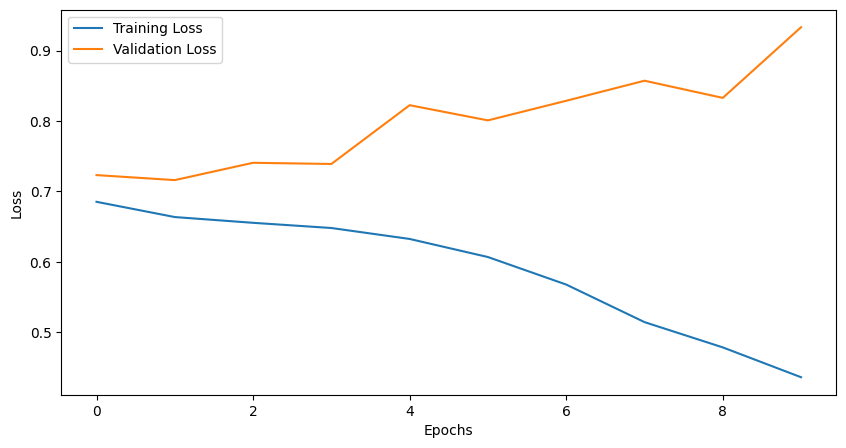

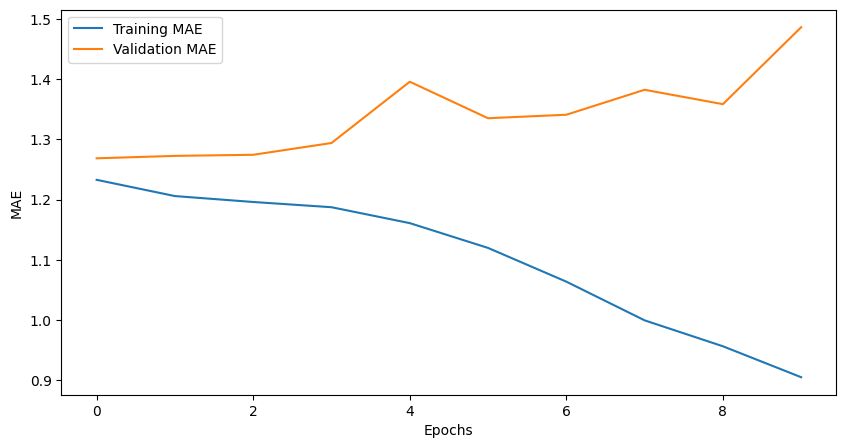

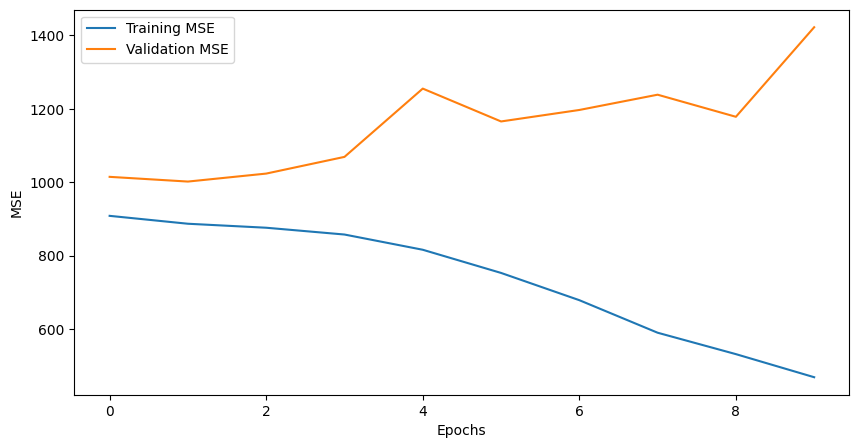

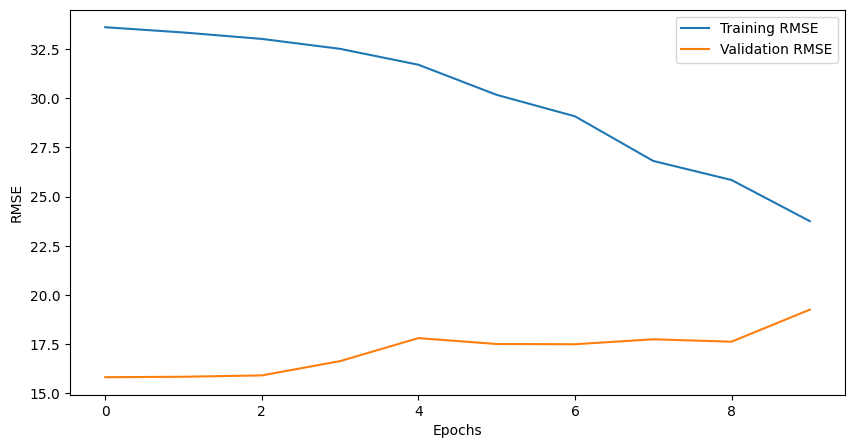

In [83]:
plt.figure(figsize=(10, 5))
plt.plot(train_loss_arr, label='Training Loss')
plt.plot(val_loss_arr, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_mae_arr, label='Training MAE')
plt.plot(val_mae_arr, label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_mse_arr, label='Training MSE')
plt.plot(val_mse_arr, label='Validation MSE')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_rmse_arr, label='Training RMSE')
plt.plot(val_rmse_arr, label='Validation RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.show()

In [84]:
torch.save(gru_model.state_dict(), f'{gru_model.__class__.__name__}.pth')
print("Model saved")

Model saved


### Model Evaluation on Test Set

In [85]:
gru_model.eval()

with torch.no_grad():
    X_test, y_test = X_test.to(device), y_test.to(device)
    y_pred_lstm, h0 = gru_model(X_test)
    y_test_np = y_test

# Inverse transform predictions and actual values
y_pred_inv_lstm = scalerY.inverse_transform(y_pred_lstm.cpu().numpy())
y_test_inv_lstm = scalerY.inverse_transform(y_test_np.cpu().numpy())

print(y_pred_inv_lstm.shape, y_test_inv_lstm.shape) # (samples, targets) (samples, targets)

# Compute evaluation metrics
mae = mean_absolute_error(y_test_inv_lstm, y_pred_inv_lstm)
mse = mean_squared_error(y_test_inv_lstm, y_pred_inv_lstm)
rmse = np.sqrt(mse)

print("GRU Model Evaluation")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")


(2426, 6) (2426, 6)
GRU Model Evaluation
Mean Absolute Error (MAE): 87.9781
Mean Squared Error (MSE): 74251.9453
Root Mean Squared Error (RMSE): 272.4921


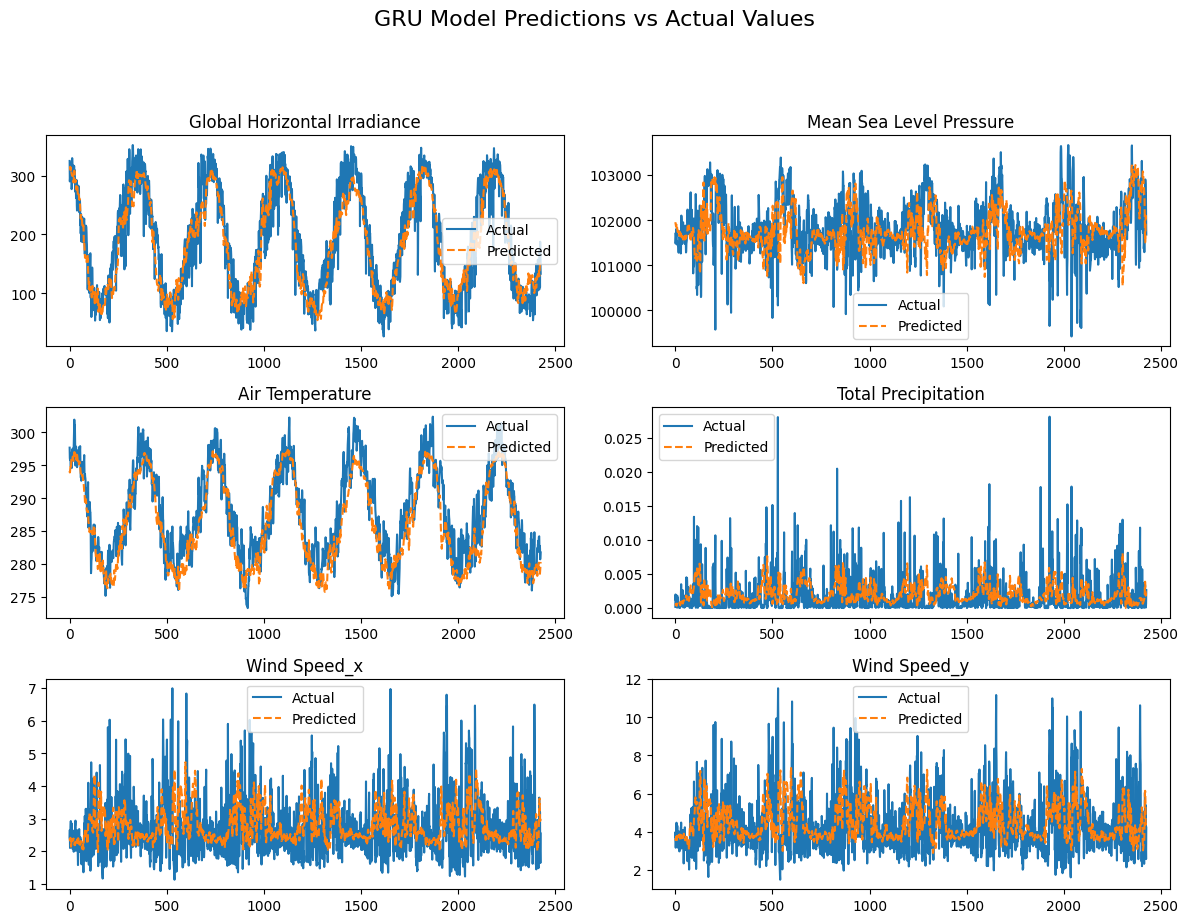

In [86]:
# Plot predictions vs actual values
num_features = len(all_features)
num_rows = (num_features + 1) // 2  # Ensure correct subplot arrangement

plt.figure(figsize=(12, num_rows * 3))
plt.suptitle("GRU Model Predictions vs Actual Values", fontsize=16)
for i, feature in enumerate(targets):
    plt.subplot(num_rows, 2, i + 1)
    plt.plot(y_test_inv_lstm[:, i], label="Actual")
    plt.plot(y_pred_inv_lstm[:, i], label="Predicted", linestyle='dashed')
    plt.title(feature)
    plt.legend()
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()